In [1]:
import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../hamp_pred/')
from utils.tools import diffangle

# lbs tools package is avaliable at https://github.com/labstructbioinf/lbs-tools
sys.path.append('/home/nfs/sdunin/scr/lbs-tools/')
from lbs.sequences import mmseqs2

In [2]:
data_dir = '../../data/input'

# referece Crick angles
crangles = {'a':19.5,'b':122.35,'c':-134.78,'d': -31.92,'e':70.92 ,'f':173.78,'g':-83.35}

In [3]:
def calc_balance(data_df, class_name, norm=True):
    
    BINS = list(np.linspace(-52, 52, 26))
    
    tmp = pd.cut(data_df[data_df['class']==class_name].rot_mean, bins=BINS, labels=False, retbins=False)#.value_counts().sort_index()
    res_vec = np.zeros(len(BINS))
    
    for g_idx, g in tmp.groupby(tmp):
        res_vec[g_idx] = len(g)

    if norm:
        res_vec = res_vec / res_vec.sum()
        
    return res_vec

In [4]:

def check_crick(row, MAXROT=55):
    return (np.abs(diffangle(row.n_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) and \
           (np.abs(diffangle(row.c_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) 

def plot(df, BINS=26):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    df['rot_mean'].plot.hist(bins=BINS, ax=ax)
    ax.axvline(x=-52, c='r')
    ax.axvline(x=52, c='r')

# Read & validate data

In [5]:
data_df = pd.read_pickle(os.path.join(data_dir, 'af2.p')) 
data_df = data_df.sample(frac=1) # shuffle rows

# calculate the relative rotation (i.e., the per-layer difference between N and C helices rotation) 
data_df['rot'] = diffangle(data_df.n_crick_mut, data_df.c_crick_mut)
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering

len(data_df)

5314

In [6]:
data_df = data_df[data_df.apply(check_crick, axis=1)]
len(data_df)

5124

<AxesSubplot: >

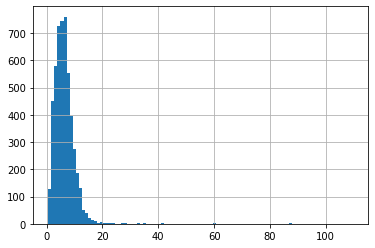

In [7]:
data_df.rot_std.hist(bins=100)

In [8]:
data_df = data_df[data_df.rot_std <= 14]
data_df = data_df[data_df.rot_mean.abs() <= 52]
len(data_df)

4972

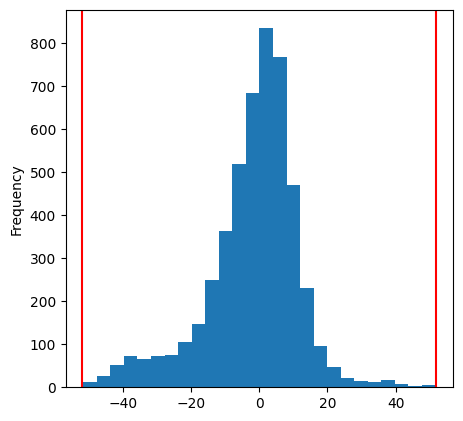

In [9]:
plot(data_df)

# Generate validation set
`random sampling`

In [12]:
MAX_VAL_FRAC = 0.2 # fraction of val in the whole set 
data_df['class'] = 'train'
val_samples = int(len(data_df)*MAX_VAL_FRAC)
val_idx = np.random.choice(data_df.index, size = val_samples, replace=False)
data_df.loc[val_idx, 'class'] = 'val'


In [13]:
data_df['class'].value_counts()

train    3978
val       994
Name: class, dtype: int64

# Check and save

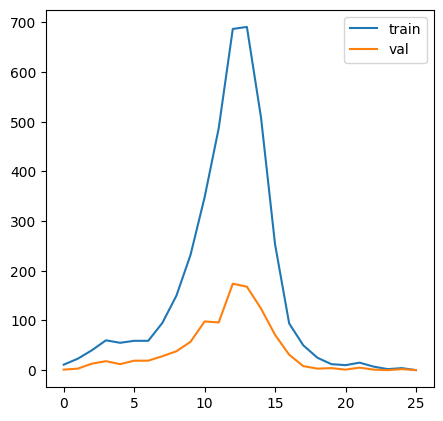

In [14]:
train_dist = calc_balance(data_df, 'train', norm=False)
val_dist = calc_balance(data_df, 'val', norm=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

ax.plot(train_dist, label='train')
ax.plot(val_dist, label='val')
ax.legend()

In [15]:
data_df['class'].value_counts()

train    3978
val       994
Name: class, dtype: int64

In [14]:
# no class balance, just the train-val split
data_df.to_pickle(os.path.join(data_dir, 'af2_clean_model_1.p'))

# Train-validation-test split (not used)

In [16]:
data_df = pd.read_pickle(
    os.path.join(data_dir, 'af2_clean_model_1.p')
)

In [17]:
tmp_df = data_df[data_df['class'] == 'val']

In [18]:
split_pos = round(len(tmp_df) / 2)

In [19]:
test_df = tmp_df.iloc[:split_pos].copy().reset_index(drop=True)
test_df['train_seq'] = test_df['n_seq'].apply(lambda x:x[1:-1]) + test_df['c_seq'].apply(lambda x:x[1:-1])
test_df = test_df[['group', 'n_rot', 'c_rot', 'rot', 'n_crick_mut', 'c_crick_mut',
       'rot_mean', 'rot_std', 'sequence', 'class', 'train_seq', 'n_seq',
       'c_seq']]


In [20]:
train_val_df = pd.concat([
    data_df[data_df['class'] == 'train'],
    tmp_df.iloc[split_pos:]
]).reset_index(drop=True)

train_val_df['train_seq'] = train_val_df['n_seq'].apply(lambda x:x[1:-1]) + train_val_df['c_seq'].apply(lambda x:x[1:-1])
train_val_df = train_val_df[['group', 'n_rot', 'c_rot', 'rot', 'n_crick_mut', 'c_crick_mut',
       'rot_mean', 'rot_std', 'sequence', 'class', 'train_seq', 'n_seq',
       'c_seq']]

In [21]:
test_df.to_pickle(os.path.join(data_dir, 'af_clean_model_test.p'))
train_val_df.to_pickle(os.path.join(data_dir, 'af_clean_model_train_val.p'))


In [22]:
# train_val_df_check = pd.read_pickle(
#     os.path.join(data_dir, 'af_clean_model_train_val.p')
# )
# train_val_df_check['train_seq'] = train_val_df_check.apply(lambda x: x['n_seq'][1:-1] + x['c_seq'][1:-1], axis=1)
# assert train_val_df_check.equals(train_val_df)


# test_df_check = pd.read_pickle(
#     os.path.join(data_dir, 'af_clean_model_test.p')
# )
# assert test_df_check.equals(test_df)

In [23]:
len(train_val_df[train_val_df['class'] == 'val'])

497

In [24]:
len(test_df[test_df['class'] == 'val'])

497

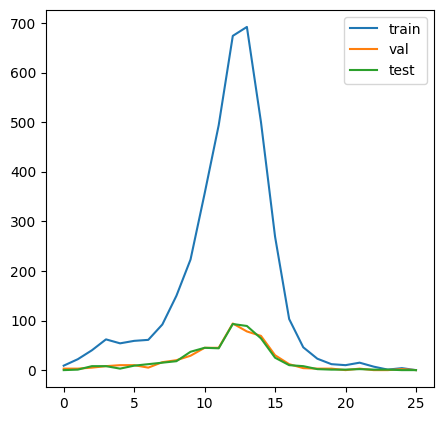

In [25]:
train_dist = calc_balance(train_val_df, 'train', norm=False)
val_dist = calc_balance(train_val_df, 'val', norm=False)
test_dist = calc_balance(test_df, 'val', norm=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

ax.plot(train_dist, label='train')
ax.plot(val_dist, label='val')
ax.plot(test_dist, label='test')
ax.legend()